In [4]:
!pip install smdebug


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
!pip install scikit-image

  Using cached scikit_image-0.20.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.2 MB)
  Using cached tifffile-2023.3.21-py3-none-any.whl (218 kB)
  Using cached PyWavelets-1.4.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.9 MB)
  Using cached lazy_loader-0.2-py3-none-any.whl (8.6 kB)
  Using cached scipy-1.9.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.9 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.0
    Uninstalling scipy-1.10.0:
      Successfully uninstalled scipy-1.10.0

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


##

In [23]:
import matplotlib.pyplot as plt

In [24]:
import sagemaker
import boto3
import os

from skimage.io import imread
from skimage import img_as_ubyte
import numpy as np

In [25]:
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

from sagemaker.pytorch import PyTorch
from sagemaker.pytorch.model import PyTorchModel

In [26]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import IPython

In [27]:
bucket= 'udacity-mle-capstone'
print("Default Bucket: {}".format(bucket))
region = 'us-east-2'
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: udacity-mle-capstone
AWS Region: us-east-2
RoleArn: arn:aws:iam::085616114435:role/service-role/AmazonSageMaker-ExecutionRole-20221221T205295


## Train initial model with profiling and debugging

In [28]:
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [43]:
estimator = PyTorch(
    entry_point='train_model.py',
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",#"ml.m5.4xlarge",
    framework_version="1.8",
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
    py_version="py36",
    source_dir="code"
)

In [44]:
estimator.fit({'train':'s3://udacity-mle-capstone/train/',
               'test':'s3://udacity-mle-capstone/test/',
               'meta':'s3://udacity-mle-capstone/meta/'
              }, 
              wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-03-29-22-36-23-991


2023-03-29 22:36:24 Starting - Starting the training job...
2023-03-29 22:36:39 Starting - Preparing the instances for training......
2023-03-29 22:37:47 Downloading - Downloading input data......
2023-03-29 22:38:48 Training - Downloading the training image......
2023-03-29 22:39:33 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-29 22:39:35,184 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-29 22:39:35,187 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-29 22:39:35,195 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-29 22:39:35,199 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-29 22:39:35,361 sagemaker-training-toolkit INFO     Installing dependencies from requiremen

In [ ]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
#print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
#print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

tj = TrainingJob(training_job_name, 'us-east-2')
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU"],
    select_events=["total"],
)

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [ ]:
estimator.jobs[-1].describe()

## Hyperparameter tuning

In [6]:
estimator = PyTorch(
    entry_point='train_model.py',
    role=role,
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    #hyperparameters=hyperparameters,
    framework_version="1.8",
    #profiler_config=profiler_config,
    #debugger_hook_config=debugger_config,
    #rules=rules,
    py_version="py36",
    source_dir="code"
)

In [11]:
hyperparameter_ranges = {
    "train-batch-size": CategoricalParameter([64, 128]),
    "lr": CategoricalParameter([0.1, 1.0])
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=4,
    objective_type=objective_type
)

In [12]:
tuner.fit({'train':'s3://udacity-mle-capstone/train/',
               'test':'s3://udacity-mle-capstone/test/',
               'meta':'s3://udacity-mle-capstone/meta/'
              }, 
              wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [13]:
tuner.best_training_job()

'pytorch-training-230329-0057-002-c72bac2b'

In [14]:
best_estimator = tuner.best_estimator()


2023-03-29 01:53:21 Starting - Preparing the instances for training
2023-03-29 01:53:21 Downloading - Downloading input data
2023-03-29 01:53:21 Training - Training image download completed. Training in progress.
2023-03-29 01:53:21 Uploading - Uploading generated training model
2023-03-29 01:53:21 Completed - Resource released due to keep alive period expiry


In [15]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"average test loss"',
 'lr': '"0.1"',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-29-00-57-13-692"',
 'sagemaker_program': '"train_model.py"',
 'sagemaker_region': '"us-east-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-2-085616114435/pytorch-training-2023-03-29-00-57-13-692/source/sourcedir.tar.gz"',
 'train-batch-size': '"128"'}

In [31]:
best_estimator.model_data

's3://sagemaker-us-east-2-085616114435/pytorch-training-230329-0057-002-c72bac2b/output/model.tar.gz'

## Deploy to endpoint and run inference on pairs of images

In [49]:
#'s3://sagemaker-us-east-2-085616114435/pytorch-training-230329-0057-002-c72bac2b/output/model.tar.gz'

estimator_trained = PyTorchModel(
    model_data = best_estimator.model_data,
    entry_point='inference.py',
    framework_version="1.8",
    py_version="py36",
    source_dir="code",
    role=role
)

In [50]:
predictor=estimator_trained.deploy(initial_instance_count=1, 
                           instance_type="ml.m5.large")

INFO:sagemaker:Creating model with name: pytorch-inference-2023-03-29-23-22-15-790
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-03-29-23-22-16-481
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-03-29-23-22-16-481


------!

In [51]:
img1 = img_as_ubyte(imread('/root/udacity-mle-capstone/project/sign_data/test/050/01_050.png', as_gray=True))
img2 = img_as_ubyte(imread('/root/udacity-mle-capstone/project/sign_data/test/050/02_050.png', as_gray=True))
img3 = img_as_ubyte(imread('/root/udacity-mle-capstone/project/sign_data/test/050_forg/02_0204050.PNG', as_gray=True))

In [52]:
response_real = predictor.predict(np.array([img1, img2], dtype='object'))
response_forged = predictor.predict(np.array([img1, img3], dtype='object'))

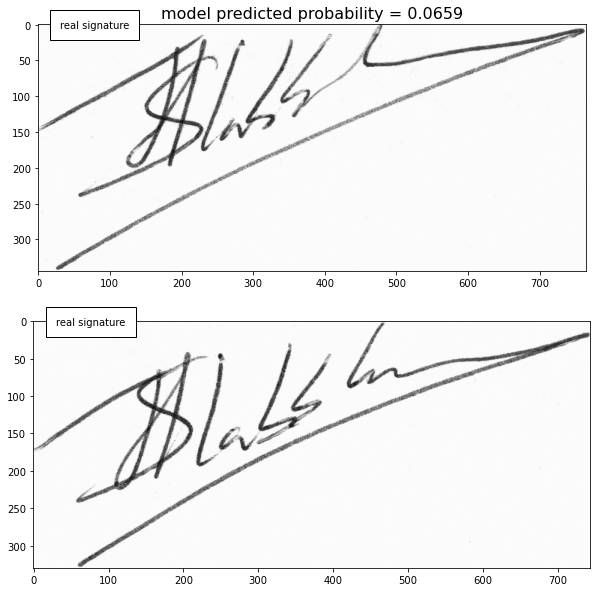

In [53]:
fig, axs = plt.subplots(2, figsize=(10, 10))
ax0,ax1 = axs
ax0.imshow(img1, cmap='binary_r', label='real')
ax1.imshow(img2, cmap='binary_r')
ax0.set_title(f'model predicted probability = {response_real:.4f}', size=16)
ax0.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10})
ax1.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10});

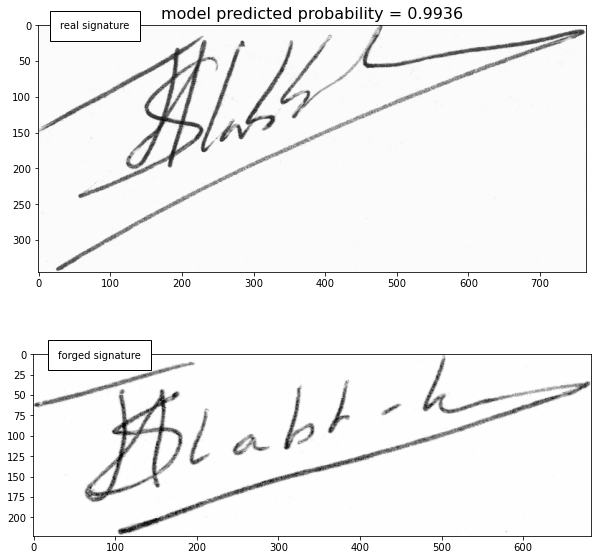

In [54]:
fig, axs = plt.subplots(2, figsize=(10, 10))
ax0,ax1 = axs
ax0.imshow(img1, cmap='binary_r')
ax1.imshow(img3, cmap='binary_r')
ax0.set_title(f'model predicted probability = {response_forged:.4f}', size=16)
ax0.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10})
ax1.text(30, 5, 'forged signature', bbox={'facecolor': 'white', 'pad': 10});

In [55]:
import pandas as pd
from tqdm import tqdm

In [56]:
test_df = pd.read_csv('/root/udacity-mle-capstone/project/sign_data/test_data.csv', header=0, names=['img_path_real', 'img_path_forged', 'label'])
test_df['img_path_real'] = test_df['img_path_real'].apply(lambda x : f'/root/udacity-mle-capstone/project/sign_data/test/{x}')
test_df['img_path_forged'] = test_df['img_path_forged'].apply(lambda x : f'/root/udacity-mle-capstone/project/sign_data/test/{x}')

In [65]:
y_pred = []
y = []
for index,row in test_df.iterrows():
    if index%100==0:
        print(index)
    try:
        img1 = img_as_ubyte(imread(row['img_path_real'], as_gray=True))
        img2 = img_as_ubyte(imread(row['img_path_forged'], as_gray=True))
        y_pred.append(predictor.predict(np.array([img1, img2], dtype='object'))) 
        y.append(row['label'])
    except:
        pass

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700


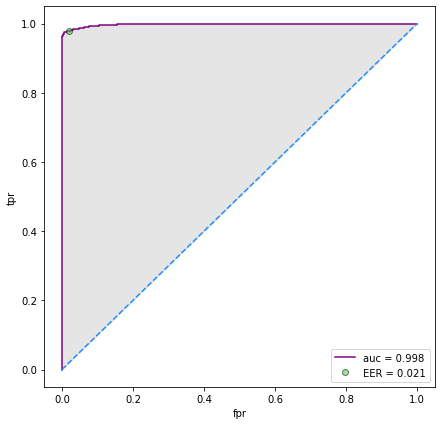

In [83]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y, y_pred, pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
eer_idx = np.nanargmin(np.abs(threshold - eer_threshold))
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(fpr, tpr, color='purple', label=f'auc = {roc_auc:.3f}')
ax.plot(fpr, fpr, '--', c='dodgerblue')
ax.fill_between(fpr, fpr, tpr, color='grey', alpha=0.2)
#ax.axvline(fpr[eer_idx], color='limegreen')
#ax.axhline(tpr[eer_idx], color='limegreen')
ax.plot(fpr[eer_idx],tpr[eer_idx],'o', mec='k', color='limegreen', alpha=0.5, label=f'EER = {EER:.3f}')
ax.legend()
ax.set_xlabel('fpr')
ax.set_ylabel('tpr');

## Cleanup: delete endpoint

In [84]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-03-29-23-22-16-481
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-03-29-23-22-16-481
